In [1]:
%matplotlib inline
import flopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pathlib as pl
import pandas as pd
from liss_settings import cx, cx_provider, extent, boxx, boxy, extentmax, fig_ext, transparent

## Load base MODFLOW model

In [2]:
ws = "../modflow/greenport500ft/base/"
sim = flopy.mf6.MFSimulation.load(sim_ws=ws, verbosity_level=0)

gwf = sim.get_model()
mg = gwf.modelgrid

nghb = gwf.ghb.stress_period_data.get_dataframe()[0].shape[0]
area = nghb * 500.0 * 500.0

## Load the coastal boundary observation data

In [3]:
sim_dirs = ["run_01.00D", "run_01.00H", "run_15.00M"]

In [4]:
sim_dict = {value: {"ws": pl.Path(f"../modflow/greenport500ft/{value}")} for value in sim_dirs}
sim_dict

{'run_01.00D': {'ws': WindowsPath('../modflow/greenport500ft/run_01.00D')},
 'run_01.00H': {'ws': WindowsPath('../modflow/greenport500ft/run_01.00H')},
 'run_15.00M': {'ws': WindowsPath('../modflow/greenport500ft/run_15.00M')}}

In [5]:
for key, value in sim_dict.items():
    obs_path = value["ws"] / "green2010_v3.ghb.obs.csv"
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2010")
    df["delt"] = df["totim"].diff()
    df.loc[df["delt"].isnull(), "delt"] = df["delt"].iloc[1]
    df.drop("totim", axis=1, inplace=True)
    df["TOTAL"] = 0.0
    for col_name in ("SOUND", "INNER", "PECONIC"):
        df["TOTAL"] += -12.0 * df[col_name] / area
    df["CUM_TOTAL"] = df["TOTAL"].cumsum() * df['delt']
    df["ZERO"] = 0.
    df.drop("delt", axis=1, inplace=True)
    sim_dict[key]["ntimes"] = df.shape[0]
    sim_dict[key]["df"] = df.copy()
    sim_dict[key]["total_in"] = df["CUM_TOTAL"].iloc[-1]

FileNotFoundError: [Errno 2] No such file or directory: '..\\modflow\\greenport500ft\\run_01.00D\\green2010_v3.ghb.obs.csv'

## Plot the coastal exchange

In [6]:
ws = pl.Path("figures")
ws.mkdir(exist_ok=True, parents=True)

In [29]:
labels = [value.split(sep="_")[1] for value in sim_dirs]
for idx, label in enumerate(labels):
    labels[idx] = f"{float(label[:5]):>2.0f}" + " " + label[-1]
labels

[' 1 D', ' 1 H', '15 M']

In [8]:
line_styles = ["-", "--", "-.", ":"]

In [9]:
colors = [value for key, value in mcolors.TABLEAU_COLORS.items()]

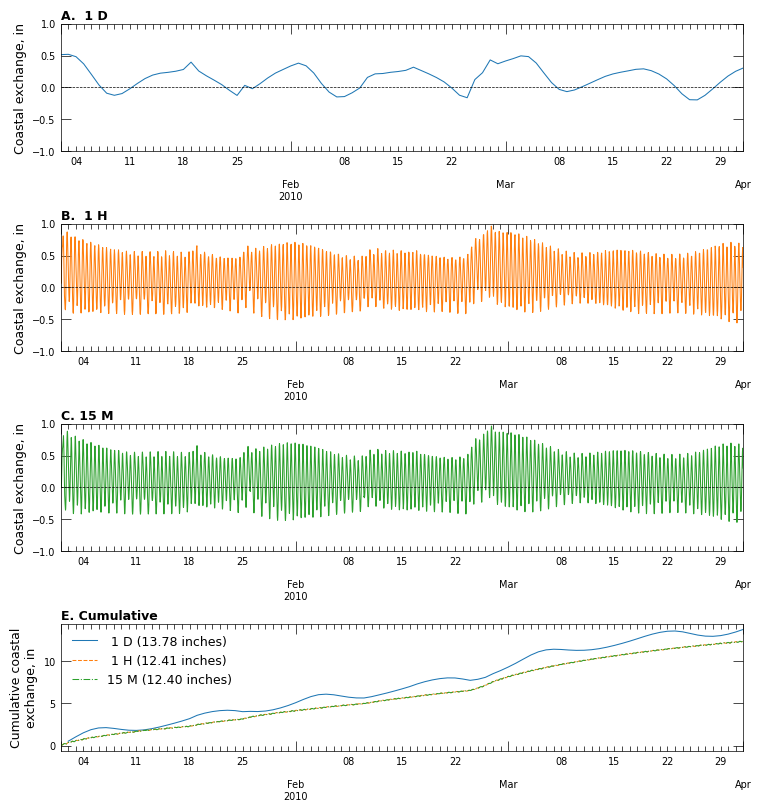

In [31]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(
        ncols=1,
        nrows=len(labels) + 1,
        layout="constrained",
        figsize=(7.5, 2 * (len(labels) + 1)),
        )
    for idx in range(len(labels)):
        ax = axs[idx]
        ax.set_ylim(-1, 1)
        df = sim_dict[sim_dirs[idx]]["df"]
        df["TOTAL"].plot(ax=ax, lw=0.75, ls="-", color=colors[idx])
        df["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black")
        ax.set_ylabel("Coastal exchange, in")
        ax.set_xlabel("")
        flopy.plot.styles.heading(ax, idx=idx, heading=labels[idx])

    ax = axs[-1]
    ax.set_ylim(0, 15)
    cum_labels = []
    for idx, value in enumerate(sim_dirs):
        total_in = sim_dict[value]["total_in"]
        cum_labels.append(f"{labels[idx]} ({total_in:5.2f} inches)")
        sim_dict[value]["df"]["CUM_TOTAL"].plot(ax=ax, lw=0.75, ls=line_styles[idx], color=colors[idx])
    ax.set_ylabel("Cumulative coastal\nexchange, in")
    ax.set_xlabel("")
    flopy.plot.styles.heading(ax, idx=len(labels) + 1, heading="Cumulative")
    
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="lower right", title="none")
    handles, previous_labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=cum_labels)

    fig.savefig(ws / f"coastal_flux_summary{fig_ext}", dpi=300, transparent=transparent)


Plot PYSWMM and GW RESULTS at nodes

In [ ]:

)

# Plotting results
# References: (https://flopy.readthedocs.io/en/latest/Notebooks/modelgrid_examples.html#Using-the-modelgrid-with-plotting-routines)
# https://flopy.readthedocs.io/en/3.3.2/index.html
# -------------------------------
# -------------------------------
# Plotting the 2D water table map
# -------------------------------
# fig, ax = plt.subplots(figsize=(15, 15), nrows=2, ncols=2, subplot_kw={"aspect": "equal"})
fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"aspect": "equal"})
plt.title("Water Table Elevation with respect to Datum (m)")
ax.plot(obs_loc, 'ok')
# mg.plot()
pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
pmv.plot_grid(lw=0.5, color="0.5")
# pmv.plot_inactive()
pc = pmv.plot_array(heads[0,:,:]*0.304)
# pmv.plot_ibound()
plt.tight_layout()
plt.colorbar(pc,label="WT (m)", shrink=.5, ax=ax, location='left')
# print(heads.shape)
rw_coords = mg.get_coords(48,57)
# print(mg.shape)
# print(rw_coords[0])
plt.plot(rw_coords[0],rw_coords[1], 'ok')

# Plotting local water table
# --------------------------
# fig, ax = plt.subplots(figsize=(10, 5),nrows=1, ncols=3)
# ax[0].set_title("Local water table")
# for i in range(head_obs.shape[1] - 1):
#     plt.plot(
#         head_obs[:, 0],
#         head_obs[:, i + 1] * 0.3048,
#         "-",
#         lw=2,
#         label=junctions[i],
#     )
# plt.xlabel("Time, day")
# plt.ylabel("Water table elevation, m above datum")
# plt.legend(loc="best", ncol=6, frameon=False)
# plt.xlim(0, 365)
# # plt.ylim(0, 2.1)
# # ax[0].set_aspect('equal')

# Plotting flow exchanges
# -----------------------
fig, ax = plt.subplots(figsize=(8, 6))
# ax[1].set_title("Flow exchange")
for j in junctions:
    plt.plot(
        sewer_obs["time"],
        -sewer_obs[j],
        "-",
        lw=2,
        label=j,
    )
plt.legend(loc="best", ncol=6, frameon=False)
plt.xlim(0, 365)
plt.xlabel("time, day")
plt.ylabel("Flow exchange (I & E), ft\u00b3/s")

# Plotting flow exchanges
# -----------------------
fig, ax = plt.subplots(figsize=(8, 6))
# ax[1].set_title("Flow exchange")
for j in junctions:
    plt.plot(
        sewer_obs["time"],
        -sewer_obs[j]*1000/0.25*0.304,
        "-",
        lw=2,
        label=j,
    )
plt.legend(loc="best", ncol=6, frameon=False)
plt.xlim(0, 365)
plt.xlabel("time, day")
plt.ylabel("Flow exchange (I & E), L/(s km)")

# Plotting total flow at WWTP
# ---------------------------
fig, ax = plt.subplots(figsize=(8, 6))
# ax[2].set_title("Flowrate at the WWTP's Inlet")
plt.xlabel("time, day")
plt.ylabel("Sewer flow, m\u00b3/s")  # in  CMS
plt.xlim(0, 365)
plt.plot(time_vec, out_array, "r-")
plt.legend(loc="best", ncol=6, frameon=False)

plt.show()

In [ ]:
from pyswmm import Output, SubcatchSeries, NodeSeries, LinkSeries, SystemSeries
 
with Output('Example1.out') as out:
    print(len(out.subcatchments))
    print(len(out.nodes))
    print(len(out.links))
    print(out.version)
 
    sub_ts = SubcatchSeries(out)['1'].runoff_rate
    node_ts = NodeSeries(out)['24'].invert_depth
    link_ts = LinkSeries(out)['16'].flow_rate
    sys_ts = SystemSeries(out).rainfall